# Notebook to accompany 'Swype Right' at www.jasmcole.com

In [244]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn.apionly as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def format_plot():
    h = plt.gca()
    h.grid('on')
    [h.spines[s].set_linewidth(1.2) for s in h.spines]
    fig = plt.gcf()
    fig.set_size_inches(6, 4)

In [3]:
def get_T():
    '''
    Calculate transition matrix from Reuters corpus
    '''
    from nltk.corpus import reuters

    words = []
    fids = reuters.fileids()
    for f in fids:
        words += list(reuters.words(f))

    text = "".join(words)
    tinds = [ord(t.upper()) for t in text]
    tinds = np.array(tinds)
    tinds = tinds[tinds > 64]
    tinds = tinds[tinds < 91]

    freqs = np.zeros((26,26))

    for i in range(len(tinds)-1):
        freqs[tinds[i]-65, tinds[i+1]-65] += 1

    T = np.zeros_like(freqs)
    for i in range(26):
        T[i,:] = freqs[i,:]/np.sum(freqs[i,:])
        
    return T, freqs

T, Tunnorm = get_T()

In [4]:
def imshowletters(I):
    '''
    Plot a 2D array ordered alphabetically
    '''
    plt.imshow(I, cmap='Blues')
    plt.xticks(np.linspace(0,25,26))
    plt.yticks(np.linspace(0,25,26))
    plt.gca().set_xticklabels([chr(i) for i in range(65,91)], ha='center');
    plt.gca().set_yticklabels([chr(i) for i in range(65,91)], ha='center');
    plt.gca().get_yaxis().set_tick_params(pad=10)
    plt.ylabel('First letter')
    plt.xlabel('Second letter')
    plt.tight_layout()

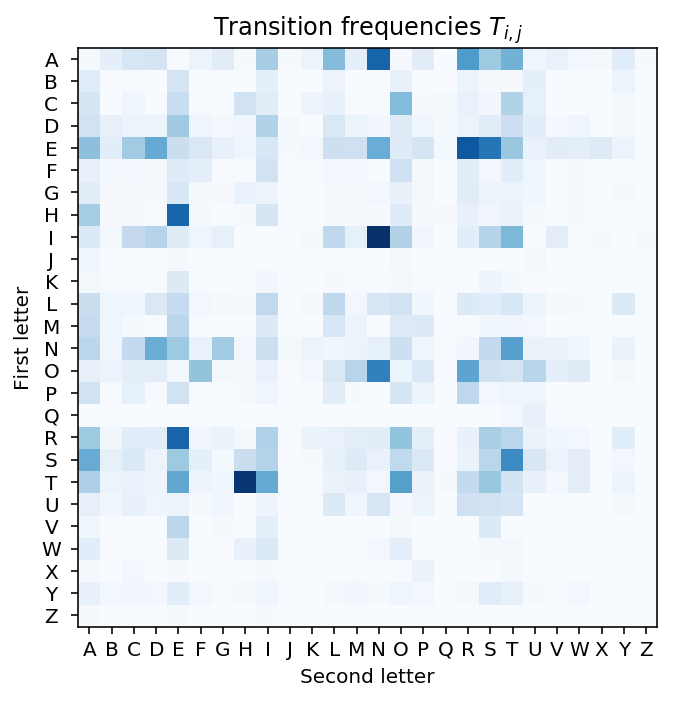

In [232]:
f, ax = plt.subplots(1,1, figsize=(5, 5))
imshowletters(Tunnorm)
plt.title('Transition frequencies $T_{i,j}$')
plt.tight_layout()
plt.savefig('TransitionFreqs.png', dpi=150)
plt.show()

In [6]:
def barletters(b):
    '''
    Plot a 1D array ordered alphabetically
    '''
    plt.bar(np.linspace(0, 25, 26), b)
    plt.xticks(np.linspace(0,25,26))
    plt.gca().set_xticklabels([chr(i) for i in range(65,91)], ha='center');
    format_plot()

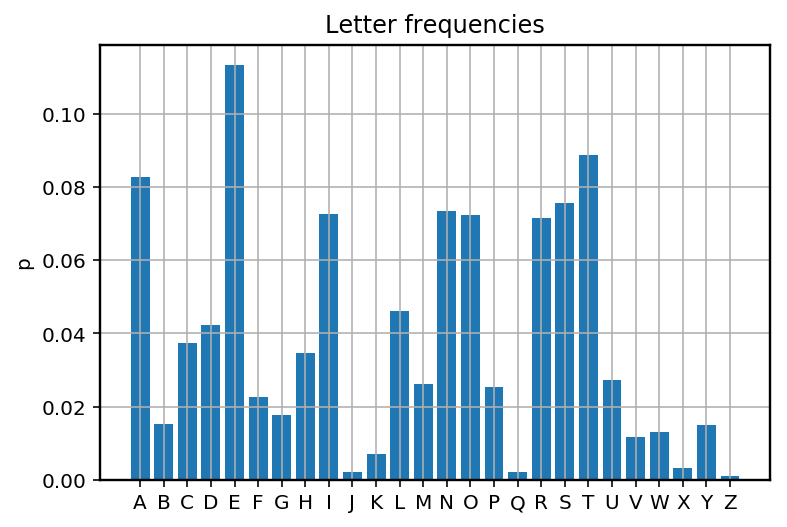

In [7]:
def get_p(T):
    '''
    Get letter occurence frequencies
    '''
    evals, evecs = np.linalg.eig(T.T)
    p = np.real(evecs[:,0])
    p = p/np.sum(p)
    return p

p = get_p(T)
barletters(p)
plt.title('Letter frequencies')
plt.ylabel('p')

In [8]:
def get_d(T, D):
    '''
    Given a transition matrix T and distance matrix D, calculate the average distance per letter vector d.
    Both matrices should be ordered alphabetically
    '''
    return np.einsum('ij,ji->i', T, D)

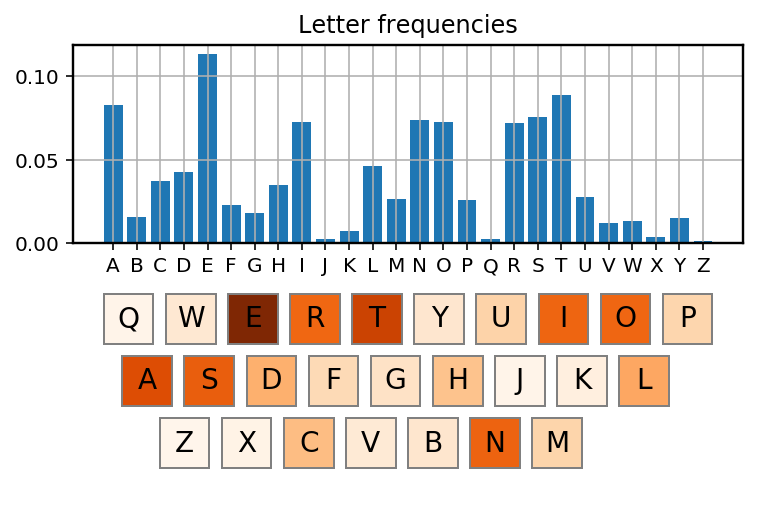

In [215]:
def draw_keyboard(letterpositions, colours):
    '''
    Draw a given keyboard state. 
    letterpositions is an array of length 26, giving the letter in each key.
    Keys are numbered from 0-25 starting from top left and ending in bottom right.
    Letters are numbered from 0-25 from A-Z.
    colours is an array giving the background colour of each key, ordered alphabetically
    '''
    import matplotlib.patches as patches
    import matplotlib.cm as cm
    cols = cm.Oranges(range(1024))
    
    r = 0.4;
    x = np.concatenate( (np.linspace(1, 10, 10), np.linspace(1, 9, 9)+0.3, np.linspace(1, 7, 7)+0.9))
    y = np.concatenate( (np.linspace(3, 3, 10),  np.linspace(2, 2, 9), np.linspace(1, 1, 7)))
    
    for i in range(len(x)):
        _x = x[i]
        _y = y[i]
        letter = letterpositions[i]
        try:
            colind = int(np.floor( (colours[letter] - np.min(colours))/(np.max(colours) - np.min(colours)) * 256))
        except:
            colind = 0
        plt.gca().add_patch(patches.Rectangle((_x-r, _y-r), 2*r, 2*r, facecolor=cols[colind,:], edgecolor='gray'))
        plt.text(_x, _y, chr(65+letter), ha='center', va='center', fontsize=14)
        
    plt.axis('image')
    plt.axis('off')  
    
qwerty = [16, 22, 4, 17, 19, 24, 20, 8, 14, 15,
          0, 18, 3, 5, 6, 7, 9, 10, 11,
          25, 23, 2, 21, 1, 13, 12]

f, ax = plt.subplots(2,1, figsize=(9,7))
plt.sca(ax[0])
barletters(p)
plt.title('Letter frequencies')
plt.sca(ax[1])
draw_keyboard(qwerty, p)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars


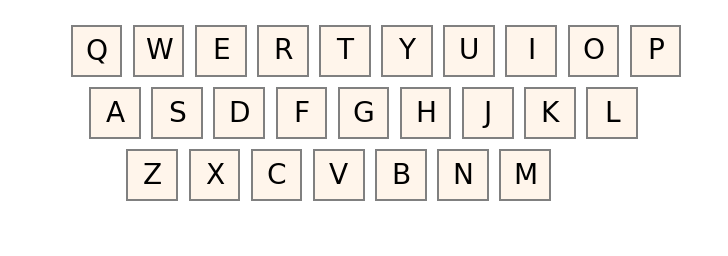

In [218]:
draw_keyboard(qwerty, np.ones_like(p))
format_plot()
plt.savefig('QWERTY.png', dpi=150)

In [10]:
def make_D():
    '''
    D[i,j] contains the distance from key i to key j.
    Counted from top-left to bottom-right.
    This must be re-arranged to get the distance matrix ordered alphabetically.
    '''
    x = np.concatenate( (np.linspace(1, 10, 10), np.linspace(1, 9, 9)+0.3, np.linspace(1, 7, 7)+0.9))
    y = np.concatenate( (np.linspace(3, 3, 10),  np.linspace(2, 2, 9), np.linspace(1, 1, 7)))
    
    D = np.zeros((len(x), len(x)))
    
    for i in range(len(x)):
        for j in range(len(x)):
            x1 = x[i]
            y1 = y[i]
            x2 = x[j]
            y2 = y[j]
            D[i,j] = np.sqrt( (x2-x1)**2 + (y2-y1)**2)
            
    return D

D = make_D()        

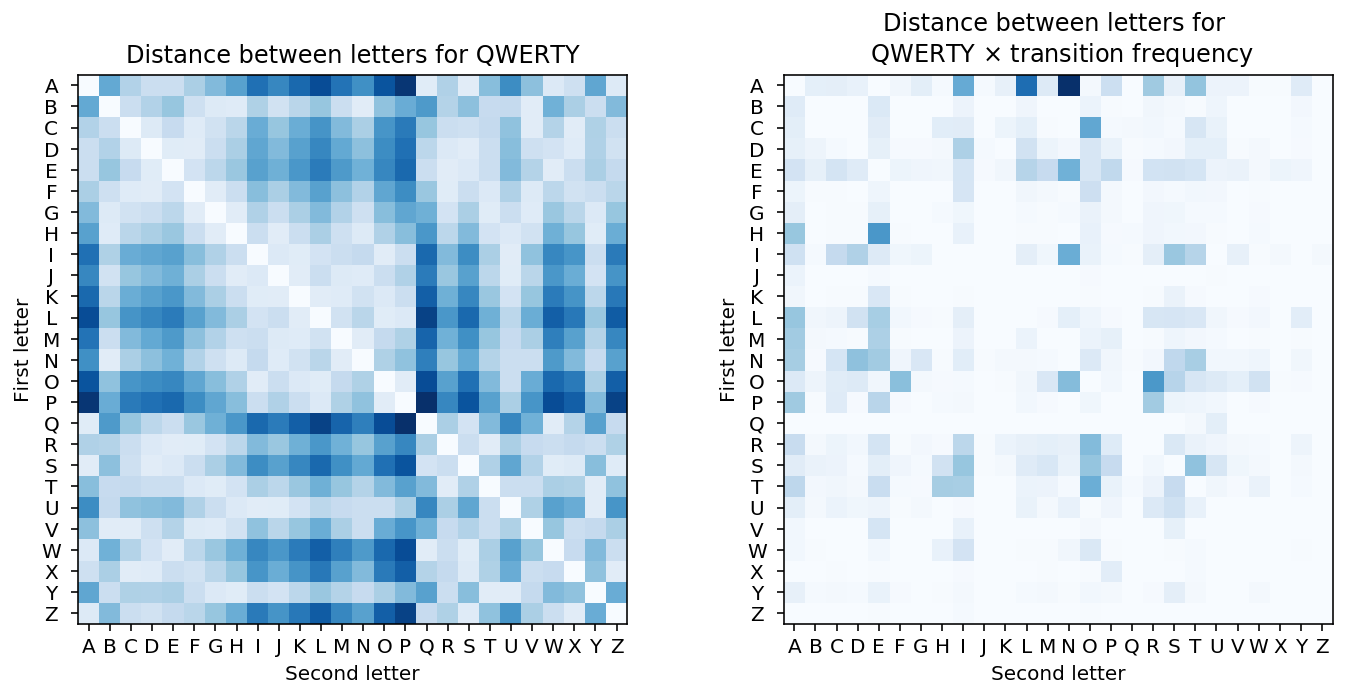

In [219]:
def alphabetise(D, qwerty):
    '''
    D needs to be ordered alphabetically
    inds contains the letter locations on the keyboard, ordered alphabetically
    '''
    
    inds = [qwerty.index(i) for i in range(26)]

    newD = D
    newD = newD[ :, inds ] # Arrange left to right
    newD = newD[ inds, : ] # Arrange top to bottom
    return newD

newD = alphabetise(D, qwerty)

f, ax = plt.subplots(1,2, figsize=(10, 5))
plt.sca(ax[0])
imshowletters(newD)
plt.title('Distance between letters for QWERTY')

plt.sca(ax[1])
imshowletters(newD * Tunnorm)
plt.title('Distance between letters for \n QWERTY $\\times$ transition frequency')

plt.tight_layout()
plt.show()

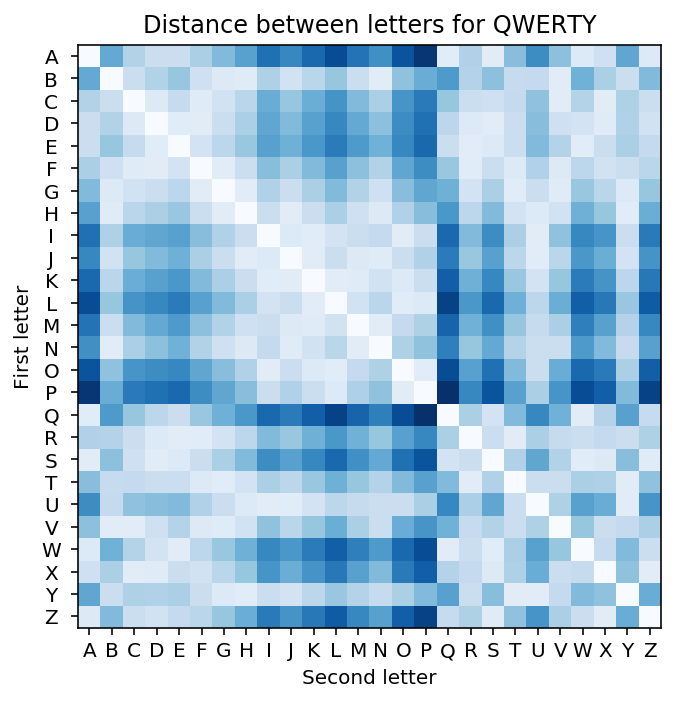

In [225]:
f, ax = plt.subplots(1,1, figsize=(5, 5))
imshowletters(newD)
plt.title('Distance between letters for QWERTY')
plt.tight_layout()
plt.savefig('QWERTYDistances.png', dpi=150)
plt.show()

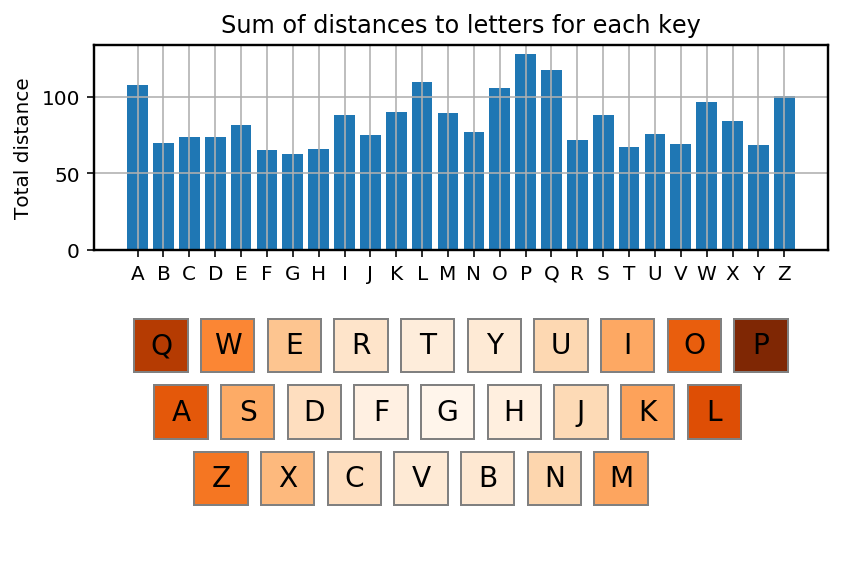

In [227]:
dlett = np.sum(newD, axis=0)

f, ax = plt.subplots(2,1, figsize=(6,4))
plt.sca(ax[0])
barletters(dlett)
plt.title('Sum of distances to letters for each key')
plt.ylabel('Total distance')
plt.sca(ax[1])
draw_keyboard(qwerty, dlett)

plt.tight_layout()
plt.savefig('Distperletter.png', dpi=150)
plt.show()

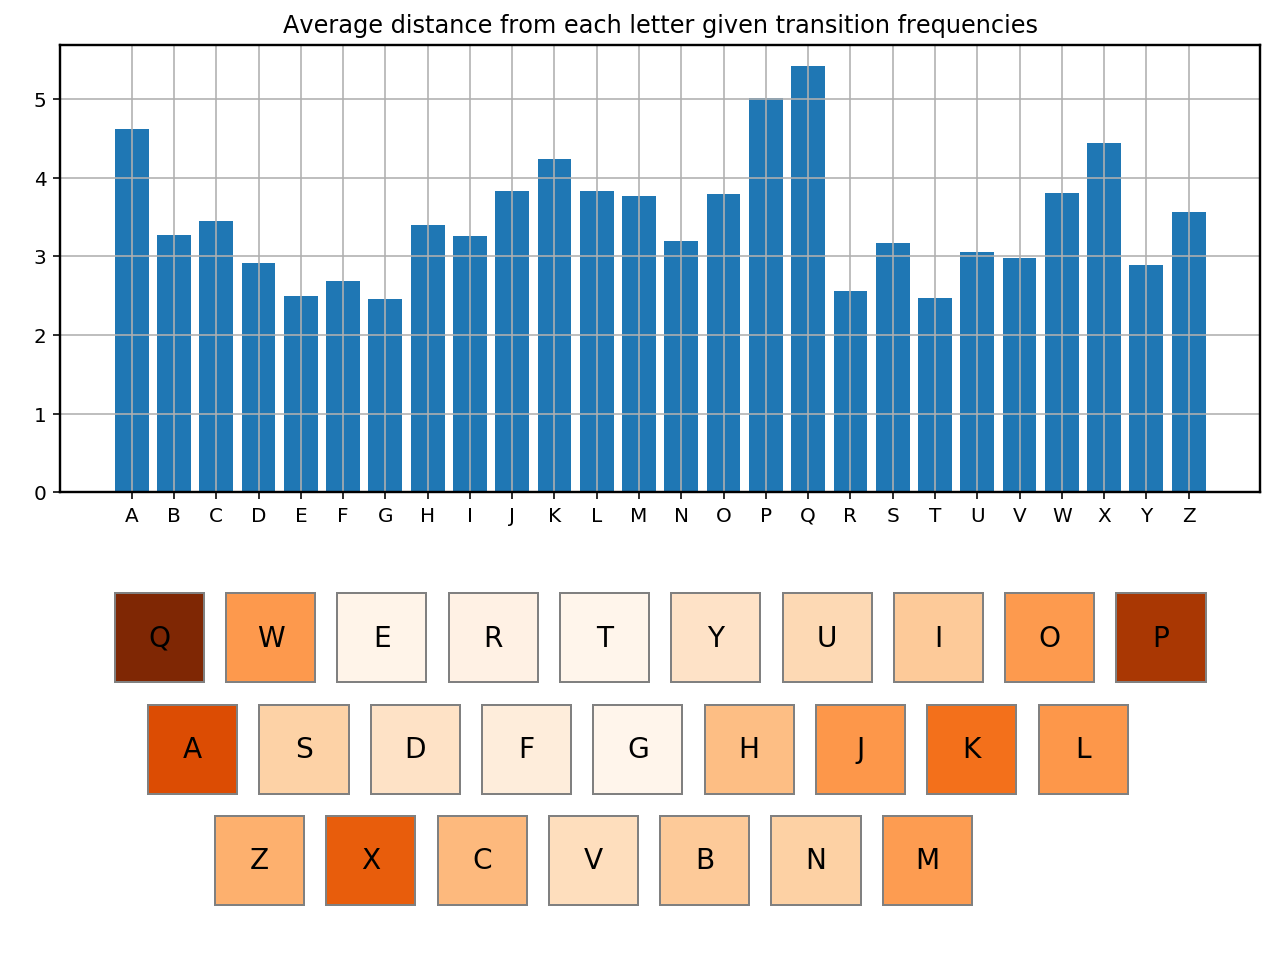

In [13]:
d = get_d(T, newD)

f, ax = plt.subplots(2,1, figsize=(9,7))
plt.sca(ax[0])
barletters(d)
plt.title('Average distance from each letter given transition frequencies')
plt.sca(ax[1])
draw_keyboard(qwerty, d)

plt.tight_layout()
plt.show()

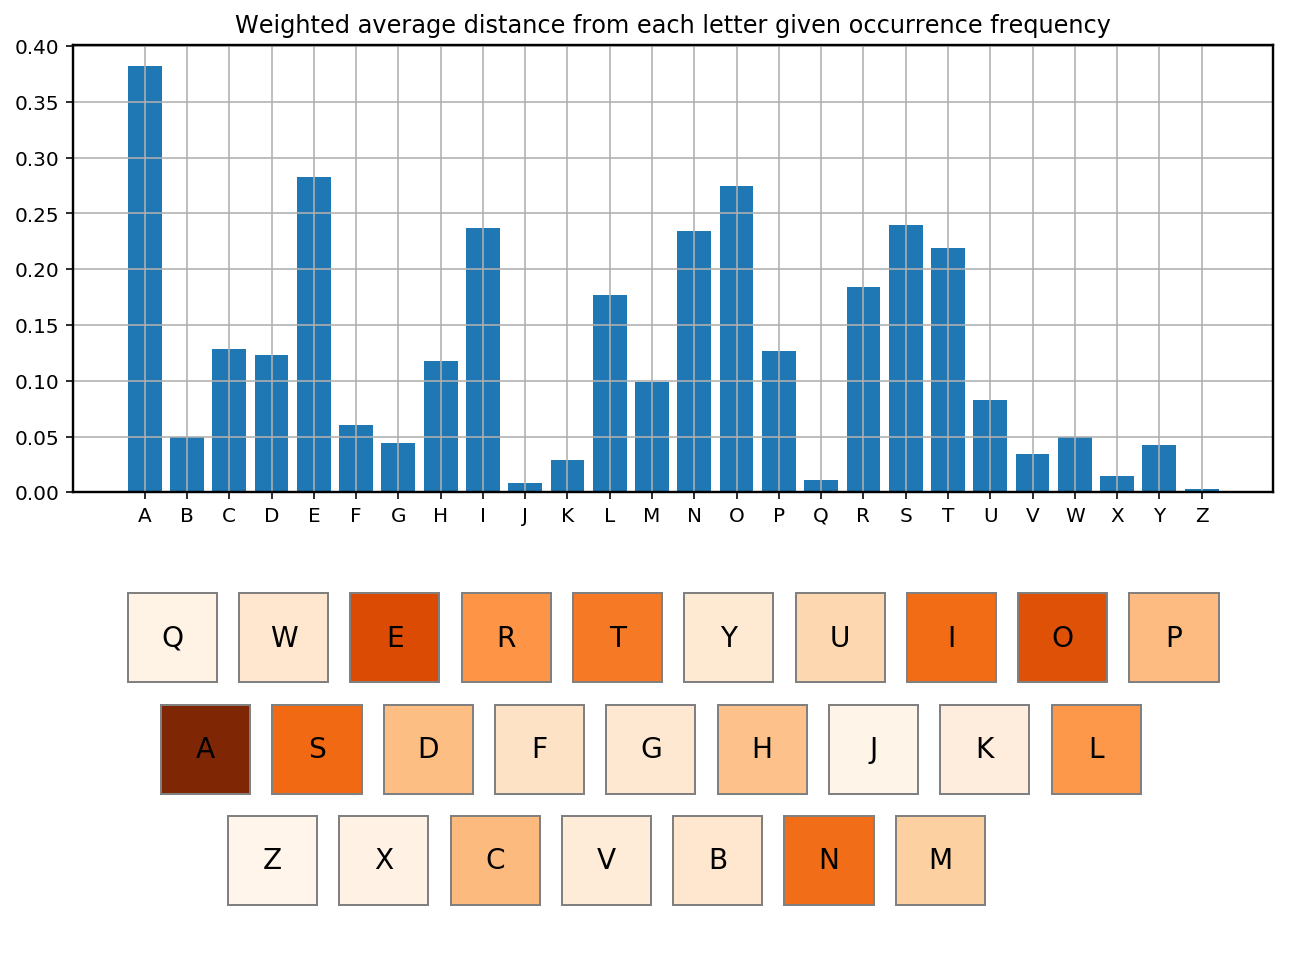

In [14]:
f, ax = plt.subplots(2,1, figsize=(9,7))
plt.sca(ax[0])
barletters(d*p)
plt.title('Weighted average distance from each letter given occurrence frequency')
plt.sca(ax[1])
draw_keyboard(qwerty, d*p)

plt.tight_layout()
plt.show()

# Simulated annealing

In [232]:
qwerty = [16, 22, 4, 17, 19, 24, 20, 8, 14, 15,
          0, 18, 3, 5, 6, 7, 9, 10, 11,
          25, 23, 2, 21, 1, 13, 12]
#T, Tunnorm = get_T() # (SLOW) Does reuters analysis
p = get_p(T) # Constant letter frequencies
D = make_D() # Constant key distances
newD = alphabetise(D, qwerty) # Alphabetical distances
d = get_d(T, newD) # Average distances given transition probabilities
dold = np.dot(p, d) # Average distance given letter frequencies

import random
temp = 5

# Rerun this as much as you want...

Nint = 1000000 # Annealing iterations
dvec = np.zeros((Nint, 1))

for n in range(Nint):
    new = old[:]
    Nswap = random.randint(1,5)
    for i in range(Nswap):
        ind1 = random.randint(0, 25)
        ind2 = random.randint(0, 25)
        new[ind1], new[ind2] = new[ind2], new[ind1]
    newD = alphabetise(D, new) # Alphabetical distances
    d = get_d(T, newD) # Average distances given transition probabilities
    dnew = np.dot(p, d) # Average distance given letter frequencies
    delta = dnew - dold
    temp *= 0.9999
    
    if np.exp(-delta/temp) > np.random.uniform():
        old = new
        dold = dnew
        dvec[n] = dnew
        dbest = d
        #print('New distance: ' + str(dold) + ', T = ' + str(temp))
        #print(old)
    
    if not n % 10000:
        print('Iteration ' + str(n) + ', distance ' + str(dold), ' T = ' + str(temp))

# Plot solution

In [21]:
def plotSolution(T, D, solution):
    newD = alphabetise(D, solution) # Alphabetical distances
    d = get_d(T, newD) # Average distances given transition probabilities
    dnew = np.dot(p, d) # Average distance given letter frequencies

    f, ax = plt.subplots(3,1, figsize=(6,11))

    from matplotlib import gridspec
    gs = gridspec.GridSpec(3, 1, height_ratios=[1, .8, 1.9])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])

    plt.sca(ax1)
    draw_keyboard(solution, d*p)
    plt.title('Average distance ' + str(np.floor(dnew*1000)/1000))
    plt.sca(ax2)
    barletters(d*p)
    plt.title('Weighted average distance from each letter')
    plt.ylim(0, 0.2)
    plt.sca(ax3)
    imshowletters(alphabetise(D, solution) * Tunnorm)
    plt.tight_layout()

# Naive hill climbing

In [43]:
def runHillClimbing():
    qwerty = [16, 22, 4, 17, 19, 24, 20, 8, 14, 15,
              0, 18, 3, 5, 6, 7, 9, 10, 11,
              25, 23, 2, 21, 1, 13, 12]
    np.random.seed()
    qwerty = list(np.random.permutation(qwerty))
    #T, Tunnorm = get_T() # (SLOW) Does reuters analysis
    p = get_p(T) # Constant letter frequencies
    D = make_D() # Constant key distances
    newD = alphabetise(D, qwerty) # Alphabetical distances
    d = get_d(T, newD) # Average distances given transition probabilities
    dold = np.dot(p, d) # Average distance given letter frequencies
    old = qwerty

    import random

    Nint = 100 # Maximum hill climbing iterations
    dvec = np.zeros((Nint, 1))
    delta = np.zeros((26,26))

    for n in range(Nint):

        for ind1 in range(26):
            for ind2 in range(26):
                new = old[:]
                new[ind1], new[ind2] = new[ind2], new[ind1]
                newD = alphabetise(D, new) # Alphabetical distances
                d = get_d(T, newD) # Average distances given transition probabilities
                dnew = np.dot(p, d) # Average distance given letter frequencies
                delta[ind1, ind2] = dnew - dold

        if np.min(delta) >= 0:
            break

        inds = np.where(delta == np.min(delta))

        if len(inds[0]) == 1:
            ind1, ind2 = inds[0][0], inds[1][0]
        else:
            ind1, ind2 = inds[0][0], inds[0][1]   

        old[ind1], old[ind2] = old[ind2], old[ind1]
        oldD = alphabetise(D, old) # Alphabetical distances
        d = get_d(T, oldD) # Average distances given transition probabilities
        dold = np.dot(p, d) # Average distance given letter frequencies

    if dold < 2.00:
        print('Solution ' + str(i) + ', distance ' + str(dold))
        print(old)
        plotSolution(T, D, old)
        plt.savefig(str(dold)[:10] + '.png', dpi=150)

In [44]:
from joblib import Parallel, delayed
Parallel(n_jobs=4)(delayed(runHillClimbing)() for i in range(10000))

Solution 90, distance 1.99522538724
[23, 22, 7, 19, 18, 2, 20, 5, 16, 25, 10, 6, 8, 4, 17, 14, 15, 1, 9, 21, 3, 13, 0, 11, 12, 24]
Solution 90, distance 1.99582453786
[9, 24, 12, 11, 0, 13, 3, 6, 10, 25, 23, 15, 20, 17, 4, 8, 2, 21, 16, 1, 5, 14, 18, 19, 7, 22]
Solution 90, distance 1.9933055472
[9, 1, 5, 14, 18, 19, 7, 22, 10, 25, 23, 15, 20, 17, 4, 8, 2, 21, 16, 24, 12, 11, 0, 13, 3, 6]
Solution 90, distance 1.99536130695
[16, 1, 5, 14, 18, 19, 7, 22, 10, 25, 9, 20, 12, 17, 4, 8, 2, 21, 23, 24, 15, 11, 0, 13, 3, 6]
Solution 90, distance 1.99802474955
[9, 5, 20, 14, 18, 19, 7, 22, 10, 25, 23, 1, 12, 17, 4, 8, 2, 21, 16, 24, 15, 11, 0, 13, 3, 6]
Solution 90, distance 1.99968179313
[23, 5, 20, 2, 18, 19, 7, 22, 16, 25, 24, 15, 14, 17, 4, 8, 6, 10, 9, 1, 12, 11, 0, 13, 3, 21]
Solution 90, distance 1.9933055472
[9, 1, 5, 14, 18, 19, 7, 22, 10, 25, 23, 15, 20, 17, 4, 8, 2, 21, 16, 24, 12, 11, 0, 13, 3, 6]
Solution 90, distance 1.99582453786
[9, 24, 12, 11, 0, 13, 3, 6, 10, 25, 23, 15, 20, 

KeyboardInterrupt: 

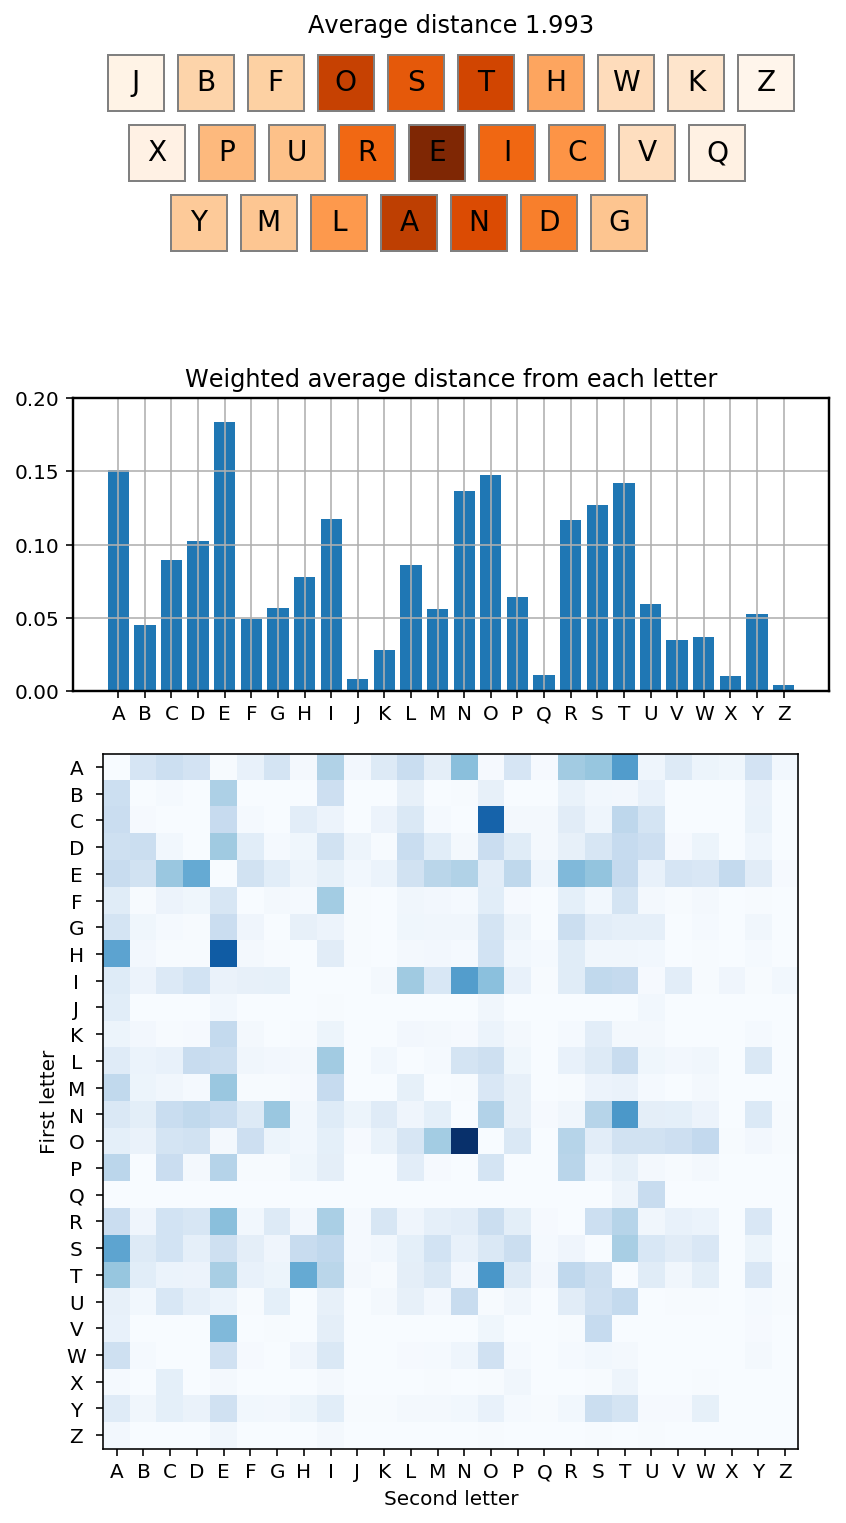

In [158]:
plotSolution(T, D, bestsol)

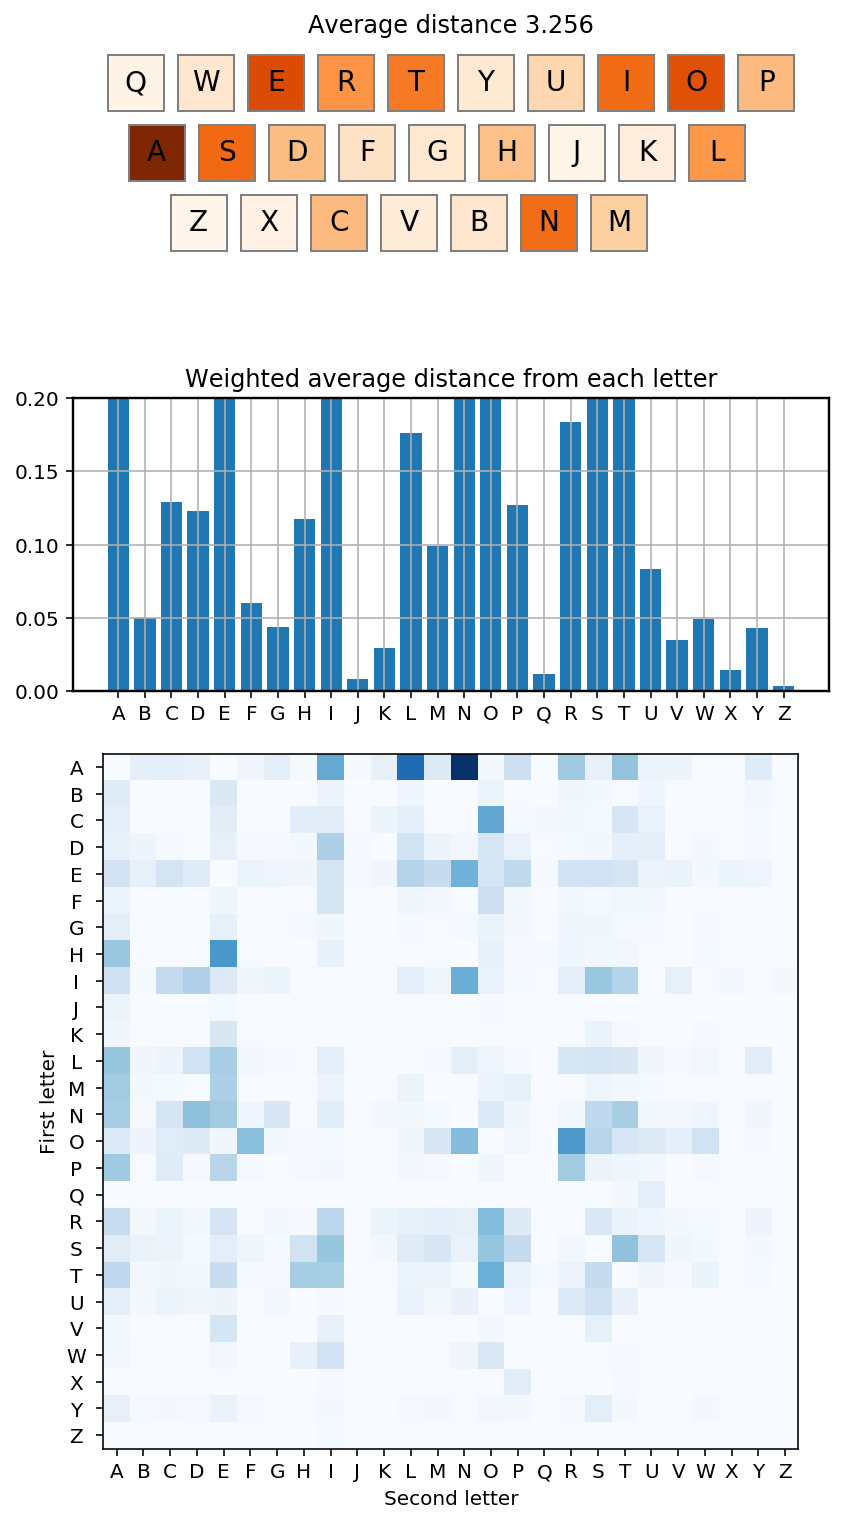

In [241]:
plotSolution(T, D, qwerty)
plt.savefig('SolutionQWERTY.png', dpi=150)
plt.show()

## Get distance required for word

In [120]:
def wordLength(word, D, solution):
    newD = alphabetise(D, solution) # Alphabetical distances
    wordlength = 0
    winds = [ord(w.upper())-65 for w in word]
    
    for i in range(len(word)-1):
        wordlength += newD[winds[i], winds[i+1]]
        
    return wordlength

bestsol = [9, 1, 5, 14, 18, 19, 7, 22, 10, 25, 23, 15, 20, 17, 4, 8, 2, 21, 16, 24, 12, 11, 0, 13, 3, 6]
print(wordLength('banana', D, qwerty))
print(wordLength('banana', D, bestsol))

27.4617811637
7.52278299076


## Get distances for all words

In [129]:
from nltk.corpus import words

worddistq = np.zeros((len(words.words()),))
worddistb = np.zeros((len(words.words()),))
wordlens = np.zeros_like(worddist)

for i, word in enumerate(words.words()):
    worddistb[i] = wordLength(word, D, bestsol)
    worddistq[i] = wordLength(word, D, qwerty)
    wordlens[i] = len(word)

## Print most irritating words for optimal layout and qwerty

In [133]:
sindsb = np.argsort(worddistb/wordlens) # sinds[0] is index of shortest word by average distance
sindsq = np.argsort(worddistq/wordlens) # sinds[0] is index of shortest word by average distance

print('Optimal, Qwerty')
for i in range(1,10):
    print(words.words()[sindsb[-i]] + ', ' + words.words()[sindsq[-i]])


Optimal, Qwerty
syzygy, palapalai
zuza, papal
wuzu, jalapa
Uzbak, papa
dozy, anapanapa
cozy, Alala
Uzbek, alala
wyke, palama
kuku, kapai


## Plot histograms of english language word distances

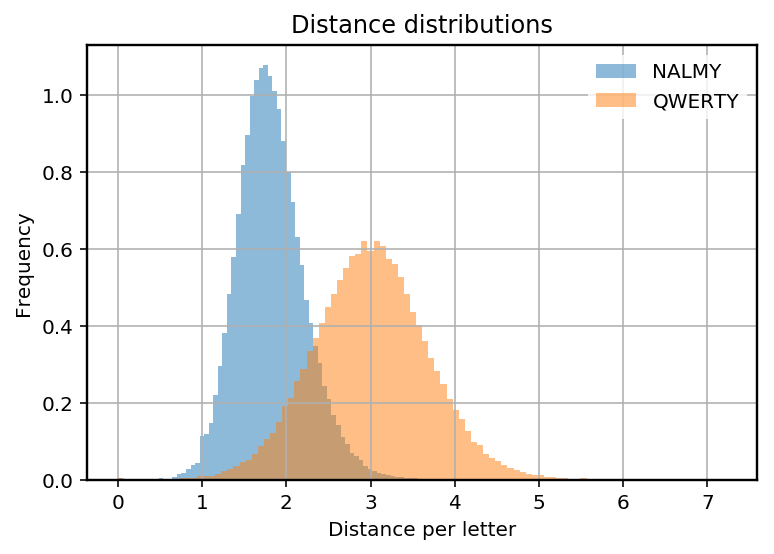

In [242]:
plt.hist(worddistb/wordlens, bins=100, alpha=0.5, normed=True, label='NALMY')
plt.hist(worddistq/wordlens, bins=100, alpha=0.5, normed=True, label='QWERTY')
plt.xlabel('Distance per letter')
plt.ylabel('Frequency')
plt.title('Distance distributions')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
format_plot()
plt.savefig('Histogram1D.png', dpi=150)
plt.show()

## Get statistics for given word

In [159]:
word = 'banana'
print('Word: ' + word)
wind = words.words().index(word)

print('Average distance per letter (qwerty): ' + str(worddistq[wind]/wordlens[wind]))
print('Irritation percentile (qwerty): ' + str(100*(np.where(sindsq == wind)[0][0]+1) / len(words.words())) + '%')

print('Average distance per letter (optimal): ' + str(worddistb[wind]/wordlens[wind]))
print('Irritation percentile (optimal): ' + str(100*(np.where(sindsb == wind)[0][0]+1) / len(words.words())) + '%')


Word: banana
Average distance per letter (qwerty): 4.57696352728
Irritation percentile (qwerty): 98.7703602325%
Average distance per letter (optimal): 1.25379716513
Irritation percentile (optimal): 6.16720735334%


## Joint distribution of word lengths

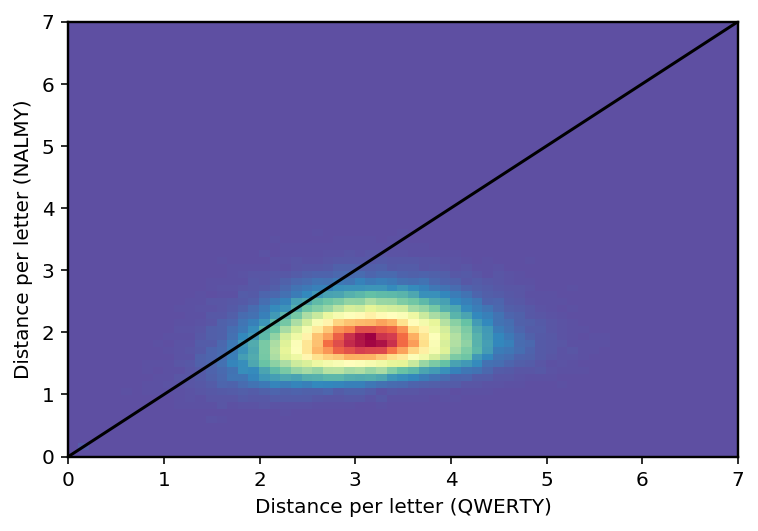

In [248]:
hist, xedges, yedges = np.histogram2d(worddistb/wordlens, worddistq/wordlens, bins=(np.linspace(-2, 9, 100)), normed=True)

plt.pcolor(yedges[1:], xedges[1:], hist, cmap='Spectral_r')
plt.plot([0, 7], [0, 7], c='black')

plt.xlim(0, 7)
plt.ylim(0, 7)
format_plot()
plt.xlabel('Distance per letter (QWERTY)')
plt.ylabel('Distance per letter (NALMY)')
plt.grid('off')
plt.savefig('Histogram2D.png', dpi=150)
plt.show()


## Which words are made much longer?

In [249]:
sindsbq = np.argsort(worddistb/worddistq)
for i in range(100):
    print(words.words()[sindsbq[i]])

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


lall
alala
Alala
ala
al
all
la
Al
aal
all
Lallan
alan
allan
Alan
Allan
lan
Os
os
soso
soss
so
so
Lalland
Lana
annal
anal
aland
alar
alani
land
land
fossor
ross
Ross
lane
Nan
anan
ana
Ana
an
Ann
ann
Anna
anana
Nana
nana
anna
nan
naa
na
mala
pallall
annale
lai
Lai
soral
ranal
alee
Alle
ale
Ella
lalang
Lanao
Alain
manal
laic
sororal
palla
Pala
alalus
oroanal
also
Alans
eland
laid
dial
solanal
Lar
lar
ie
salal
annals
nane
lealand
Tanala
malar
oral
rosland
Lao
halal
roral
foal
mall
mal
lam
amala
Furlan
Sosia
proso
ula
